# Soil Types
A classification model to determine soil type by image.

* **Input:** Image
* **Output:** Class
    * Black Soil
    * Cinder Soil
    * Laterite Soil
    * Peat Soil
    * Yellow Soil

Connect Google Colab to Drive

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import Liberaries and Modules

In [4]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model 
from tensorflow.keras.applications.inception_v3 import InceptionV3 
from tensorflow.keras.applications.inception_v3 import preprocess_input 
from tensorflow.keras.preprocessing import image 
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img 
from tensorflow.keras import models 
from sklearn.model_selection import train_test_split
import tensorflow as tf 
import os
import tensorflow_datasets as tfds
import numpy as np
import glob 
import matplotlib.pyplot as plt 
from keras.models import load_model
import json
import joblib
import cv2

## Get the Data

In [6]:
imageSize = 224
batchSize = 25
inputShape=(batchSize, imageSize,imageSize,3)

In [7]:
dataSet = tf.keras.preprocessing.image_dataset_from_directory(
  "/content/drive/MyDrive/AgriWise/ML/soil type/new_soil_types",
    shuffle = True, 
    image_size = (imageSize, imageSize),
    batch_size = batchSize
)

Found 2670 files belonging to 5 classes.


## Data Exploration

In [8]:
Categories = dataSet.class_names
print("Categories are : ", Categories)

Categories are :  ['Black Soil', 'Cinder Soil', 'Laterite Soil', 'Peat Soil', 'Yellow Soil']


In [9]:
print("length of the data set: ", len(dataSet))

length of the data set:  107


In [10]:
for image_batch, label_batch in dataSet.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(25, 224, 224, 3)
[0 0 0 0 4 0 1 0 3 0 4 0 0 0 0 4 1 0 0 0 0 2 2 1 1]


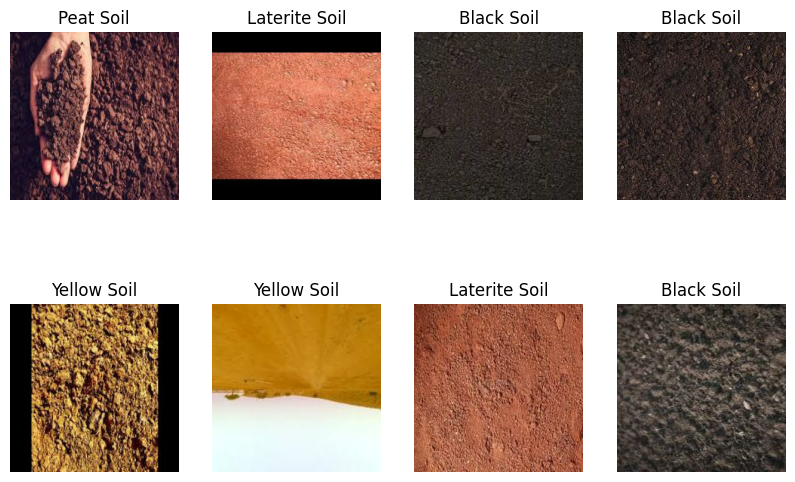

In [11]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataSet.take(1):
    for i in range(8):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8")) 
        plt.title(Categories[label_batch[i]])
        plt.axis("off")

## Data Preprocessing

A function to spilt data into train and validation sets

In [12]:
def train_valid_split(dataset, train_split = 0.8, valid_split=0.2, shuffle=True, shuffle_size=10000):
    
    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=12)
    
    n_train = train_split * len(dataset)
    train_data = dataset.take(int(n_train))
    valid_data = dataset.skip(int(n_train))

    print("Train size: ",len(train_data))
    print("Valid size: ", len(valid_data))
    return train_data, valid_data

In [13]:
trainSet, validSet = train_valid_split(dataSet)

Train size:  85
Valid size:  22


In [14]:
trainSet = trainSet.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validSet = validSet.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
from tensorflow.keras import layers 
    
rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(imageSize, imageSize),
    layers.experimental.preprocessing.Rescaling(1.0/224)
])

In [16]:
dataAugmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

## MobileNet

In [17]:
import tensorflow_hub as hub
mobileNet = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'

In [18]:
nClasses = len(Categories)

model = models.Sequential([
    rescale,
    dataAugmentation, 
    tf.keras.layers.InputLayer(input_shape=inputShape, dtype=tf.float32),
    hub.KerasLayer(mobileNet, trainable=False, dtype=tf.float32),
    Flatten(),
    Dense(5,activation='softmax')
])

In [19]:
model.build(inputShape)

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (25, 224, 224, 3)         0         
                                                                 
 sequential_1 (Sequential)   (25, 224, 224, 3)         0         
                                                                 
 input_1 (InputLayer)        multiple                  0         
                                                                 
 keras_layer (KerasLayer)    (25, 1280)                2257984   
                                                                 
 flatten (Flatten)           (25, 1280)                0         
                                                                 
 dense (Dense)               (25, 5)                   6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-tr

In [21]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [22]:
n_epochs = 50

history = model.fit(
    trainSet,
    epochs = n_epochs, 
    batch_size = batchSize,
    verbose=1,
    validation_data=validSet
)

Epoch 1/50
85/85 [==============================] - 367s 125ms/step - loss: 0.7502 - accuracy: 0.7406 - val_loss: 0.4424 - val_accuracy: 0.8545
Epoch 2/50
85/85 [==============================] - 3s 39ms/step - loss: 0.3465 - accuracy: 0.9014 - val_loss: 0.2885 - val_accuracy: 0.9164
Epoch 3/50
85/85 [==============================] - 4s 50ms/step - loss: 0.2306 - accuracy: 0.9373 - val_loss: 0.2351 - val_accuracy: 0.9309
Epoch 4/50
85/85 [==============================] - 3s 40ms/step - loss: 0.1904 - accuracy: 0.9533 - val_loss: 0.1891 - val_accuracy: 0.9545
Epoch 5/50
85/85 [==============================] - 3s 40ms/step - loss: 0.1594 - accuracy: 0.9613 - val_loss: 0.1704 - val_accuracy: 0.9564
Epoch 6/50
85/85 [==============================] - 3s 40ms/step - loss: 0.1414 - accuracy: 0.9656 - val_loss: 0.1516 - val_accuracy: 0.9636
Epoch 7/50
85/85 [==============================] - 3s 41ms/step - loss: 0.1142 - accuracy: 0.9755 - val_loss: 0.1347 - val_accuracy: 0.9600
Epoch 8/50

In [23]:
def draw_acc_loss(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(acc) + 1)
  #Train and validation accuracy
  plt.plot(epochs, acc, 'b', label='Training accurarcy')
  plt.plot(epochs, val_acc, 'g', label='Validation accurarcy')
  plt.title('Training and Validation accurarcy')
  plt.legend()
  plt.figure()
  #Train and validation loss
  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'g', label='Validation loss')
  plt.title('Training and Validation loss')
  plt.legend()
  plt.show()

## Results

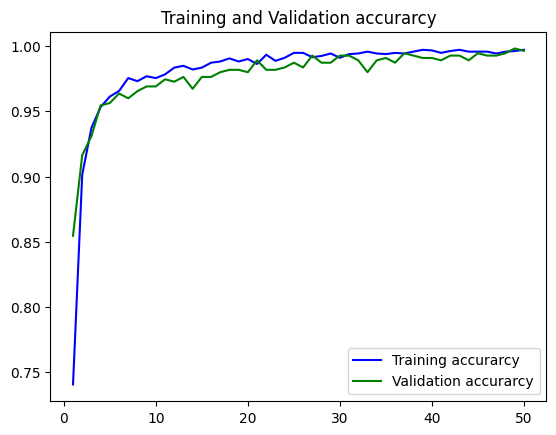

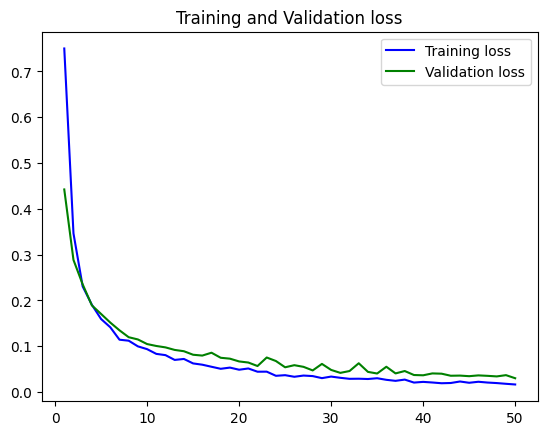

In [24]:
draw_acc_loss(history)

In [27]:
cd "/content/drive/MyDrive/AgriWise/ML/soil type/"

/content/drive/.shortcut-targets-by-id/1nNpHsxhVob0qpN6DIX6h02v09VRuwzHw/AgriWise/ML/soli type


Save the model

In [28]:
model.save("Soil Types.h5")

## Testing

In [30]:
from tensorflow.keras.utils import CustomObjectScope
with CustomObjectScope({'KerasLayer': tf.keras.layers.Layer}):
    model =  tf.keras.models.load_model("Soil Types.h5", custom_objects={'KerasLayer':hub.KerasLayer})

In [31]:
def preprocessing(img_path):
        # Load image
        img = cv2.imread(img_path)

        #Resize image to 224x224
        img = cv2.resize(img, (224, 224))

        # Add batch dimension
        img = np.expand_dims(img, axis=0)

        return img

In [32]:
def predict(input_data):
        return model.predict(input_data)

In [33]:
def postprocessing(prediction):
        categories = Categories
        # ['Black Soil', 'Cinder Soil', 'Laterite Soil', 'Peat Soil', 'Yellow Soil']
        index_max_predict = np.argmax(prediction)
        return categories[index_max_predict]

In [34]:
def compute_prediction(input_data):
        try:
            input_data = preprocessing(input_data)
            prediction = predict(input_data)[0]  # only one sample
            prediction = postprocessing(prediction)
        except Exception as e:
            return {"status": "Error", "message": str(e)}

      
        return prediction

In [35]:
compute_prediction("/content/drive/MyDrive/AgriWise/ML/soil type/model2/Soil types/Yellow Soil/Yellow_Soil_ (1).jpg")

1/1 [==============================] - 1s 947ms/step


'Yellow Soil'

In [36]:
compute_prediction("/content/drive/MyDrive/AgriWise/ML/soil type/model2/Soil types/Cinder Soil/Cinder_Soil_ (1).jpg")

1/1 [==============================] - 0s 50ms/step


'Cinder Soil'